In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import sys
csv.field_size_limit(sys.maxsize)

%matplotlib inline

from pprint import pprint

In [2]:
def load_df(csv_path='./data/train1000.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [column + '.' + subcolumn for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

In [3]:
JSON_COLUMNS_NEST = ['device', 'geoNetwork', 'totals', 'trafficSource']
JSON_COLUMNS = ['channelGrouping', 'visitNumber', 'visitStartNumber']

total_fea = ['pageviews', 'hits']
traffic_fea = ['medium','keyword', 'source', 'referralPath', 'isTrueDirect']
geo_fea = ['networkDomain','city','metro','region','country','continent','subContinent']
device_fea = ['deviceCategory','operatingSystem', 'browser']
fea = { 'device': device_fea, 'geoNetwork': geo_fea, 'totals': total_fea, 'trafficSource': traffic_fea}

na = ["not available in demo dataset", "(not provided)","(not set)", "<NA>", "unknown.unknown", "(none)"]

csv_path='./data/train_v2.csv'
extract_csv = './data/train_extract.csv'

dic = {}

count = 903653

with open(csv_path) as fp:  
    reader = csv.reader(fp)
    row1 = next(reader)
    with open(extract_csv, 'a') as f:
        w = csv.writer(f)
        w.writerow(row1)
        
    for col in row1:
        if col in JSON_COLUMNS_NEST:
            for _, feat in enumerate(fea[col]):
                dic[str(col+ '.'+ feat)] = 0   
        if col in JSON_COLUMNS:
            dic[str(col)] = 0 
    
    while (1):
        
        row = next(reader)
        row_standby = row.copy()
        d = json.dumps(row)
        g = json.loads(d)

        for col in row1:
            if col in JSON_COLUMNS_NEST:
                subobj = json.loads(row[row1.index(col)])
                for _, feat in enumerate(fea[col]):
#                     print(col, feat)
                    try:
                        if subobj[feat] in na:
                            dic[str(col+ '.'+ feat)]+=1
                    except KeyError as error:
                        dic[str(col+ '.'+ feat)]+=1
        count-=1
        if count < 1:
            break

In [4]:
pprint(dic)

{'channelGrouping': 0,
 'device.browser': 2,
 'device.deviceCategory': 0,
 'device.operatingSystem': 5967,
 'geoNetwork.city': 525064,
 'geoNetwork.continent': 1267,
 'geoNetwork.country': 1267,
 'geoNetwork.metro': 698061,
 'geoNetwork.networkDomain': 405810,
 'geoNetwork.region': 515711,
 'geoNetwork.subContinent': 1267,
 'totals.hits': 0,
 'totals.pageviews': 117,
 'trafficSource.isTrueDirect': 621365,
 'trafficSource.keyword': 860260,
 'trafficSource.medium': 309831,
 'trafficSource.referralPath': 594396,
 'trafficSource.source': 39,
 'visitNumber': 0}


<Container object of 19 artists>

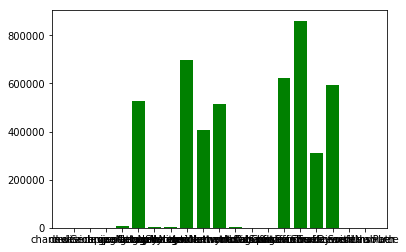

In [5]:
plt.bar(dic.keys(), dic.values(), color='g')